##### This is a script that trains a 2D-Unet model on a downsampled unprocessed HCP 7T resting state fMRI dataset.

Unet implementation by Milesial is used: https://github.com/milesial/Pytorch-UNet

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import json

import torch as t
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from dataset_management import LS_dataset_subj, LS_dataset_subjSave
from UNet2D_trainers import train_and_eval, take_a_look, test_set_recon_n_save
# 2D-UNet model imported here, path need to be included
import unet


t_seed = t.manual_seed(2112)
n_seed = random.seed(0)
np_seed = np.random.seed(0)

device = t.device("cuda" if t.cuda.is_available() else "cpu")
dtype_pt = t.float32
print(device)

TRAIN_INPUT_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Training_data/LS_imgs'
TRAIN_LABEL_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Training_data/Original_fMRI'

TEST_INPUT_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/LS_imgs'
TEST_LABEL_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/Original_fMRI'


EPOCHS = 20

cuda


In [5]:
total_data = LS_dataset_subj(TRAIN_LABEL_PATH, TRAIN_INPUT_PATH)

Datasets = random_split(total_data, [0.9397, 0.0603], generator=t.Generator().manual_seed(2112))

train_set = DataLoader(Datasets[0], batch_size=4, shuffle=True, num_workers=2)
val_set = DataLoader(Datasets[1], batch_size=1, shuffle=False, num_workers=2)

Time: 2211 min

In [3]:
t.manual_seed(2112)

Unet2D = unet.unet_model.UNet(n_channels=1, n_classes=1)

Unet2D.type(dtype_pt)
Unet=Unet2D.to(device=device)

optimizer = t.optim.Adam(Unet2D.parameters(), lr=1e-3, amsgrad=True)

loss_fn = nn.MSELoss()

train_loss, val_loss, val_hists = train_and_eval(
                                EPOCHS, 
                                train_set, 
                                val_set, 
                                Unet2D, 
                                optimizer, 
                                loss_fn,
                                device,
                                num_augment=1,
                                model_savename='Unet2D_onVol_optim.pt')


Validating Epoch 20: 100%|████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/batch, loss=1.01]


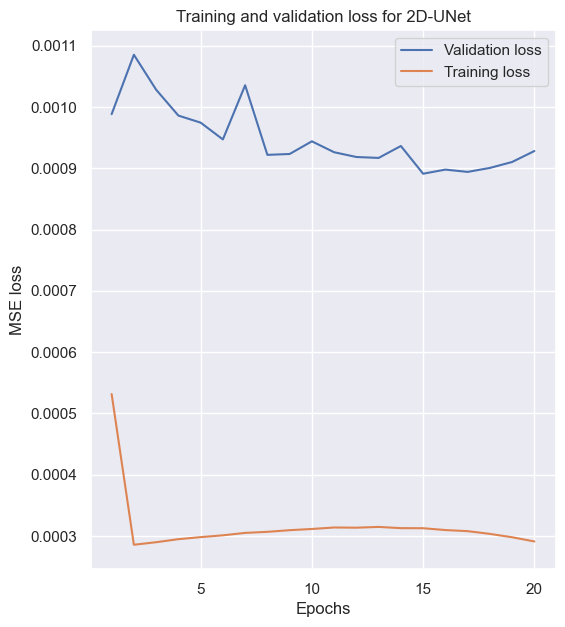

In [4]:
import seaborn as sns
sns.set()

with open('train_metrics/UNet2D-train_metrics_1e3.json') as json_file:
            train_metrics = json.loads(json_file.read())

x_ax = range(1, EPOCHS+1)

plt.figure(figsize=(6,7))
plt.plot(x_ax, [this_loss/(10*50*2) for this_loss in train_metrics["val_loss"]], label='Validation loss')
plt.plot(x_ax, [this_loss/(156*50*2) for this_loss in train_metrics["train_loss"]], label='Training loss')


plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss")
plt.title('Training and validation loss for 2D-UNet')
plt.legend()
plt.show()

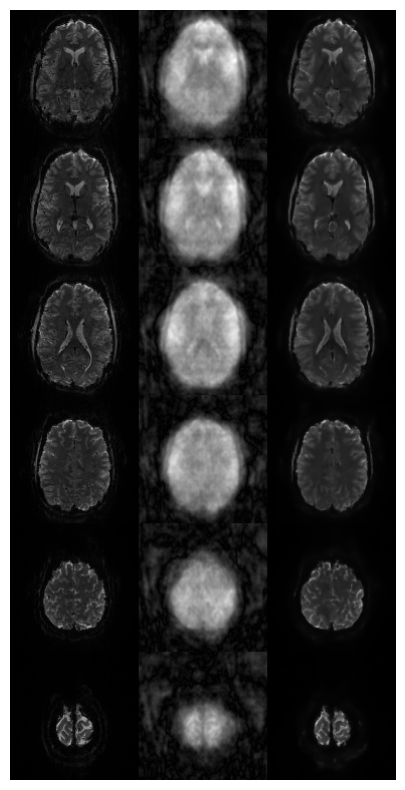

In [3]:
Unet2D = unet.unet_model.UNet(n_channels=1, n_classes=1)
Unet2D.load_state_dict(t.load('E:/Master_Project_Marius/models_bckup/2D-UNET-unproc/Unet2D_1e3_optim.pt'))

take_a_look(Unet2D, val_set, device, subindex = 0)

In [6]:
SAVEPATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/DL_recon/2D-UNet'

total_data_test = LS_dataset_subjSave(TEST_INPUT_PATH)
test_set = DataLoader(total_data_test, batch_size=1, shuffle=False)

test_set_recon_n_save(Unet2D, test_set, device, SAVEPATH, '_Unproc_2dUNet_recon.nii')

Subject 654552: 100%|██████████| 900/900 [02:28<00:00,  6.06volume/s]
